In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from keras import Sequential
from keras.utils import pad_sequences,to_categorical
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding,Dense,LSTM
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from string import punctuation

In [2]:
data=pd.read_csv("Tweets.csv")
df=pd.DataFrame(data=data)
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
X=df[['text']]
y=df['airline_sentiment']
X

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...
...,...
14635,@AmericanAir thank you we got on a different f...
14636,@AmericanAir leaving over 20 minutes Late Flig...
14637,@AmericanAir Please bring American Airlines to...
14638,"@AmericanAir you have my money, you change my ..."


In [5]:
y

0         neutral
1        positive
2         neutral
3        negative
4        negative
           ...   
14635    positive
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 14640, dtype: object

In [6]:
y.value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

<Axes: xlabel='airline_sentiment', ylabel='count'>

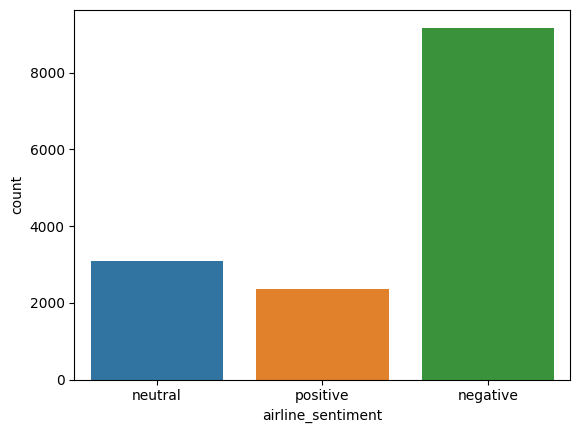

In [10]:
sns.countplot(x=y,hue=y)

In [21]:
lbl=LabelEncoder().fit(y)
y=lbl.transform(y)
lbl.classes_

array([0, 1, 2], dtype=int64)

In [25]:
ros=RandomOverSampler(random_state=44)
X,y=ros.fit_resample(X,y)
X.shape,y.shape

((27534, 1), (27534,))

<Axes: ylabel='count'>

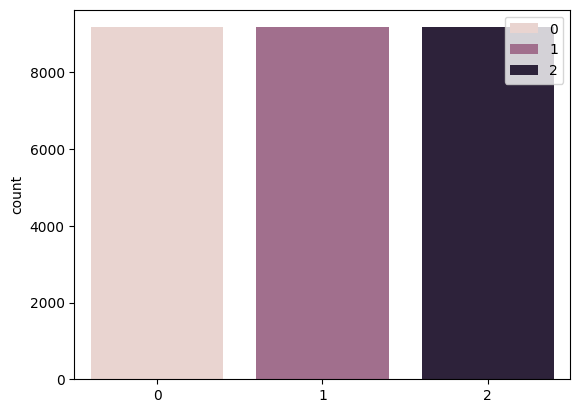

In [ ]:
sns.countplot(x=y,hue=y)

In [26]:
def preprocess(x):
    
    lemm=WordNetLemmatizer()

    txt=re.sub(r"@+[a-zA-Z]+"," ", x)
    txt=re.sub(r"[^a-zA-Z]"," ", txt)
    tok=word_tokenize(txt.lower())
    
    tok=[i for i in tok if i not in punctuation]
    
    filtered_text=[i for i in tok if i not in stopwords.words('english')]
        
    lemmatized=[lemm.lemmatize(i) for i in filtered_text]
    
    final_txt=" ".join(lemmatized)
    
    return final_txt

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=44,shuffle=True,stratify=y,test_size=0.25)

In [39]:
"Train shape : ", X_train.shape,y_train.shape

('Train shape : ', (20650, 1), (20650,))

In [40]:
"Test shape : ", X_test.shape,y_test.shape

('Test shape : ', (6884, 1), (6884,))

In [41]:
X_train=X_train['text'].apply(preprocess)
X_test=X_test['text'].apply(preprocess)
X_train

11019    least could make caused ruining people memory ...
7276     work fly fi plus access abc app spent still mi...
10140    told get percentage every plastic bottle sold ...
14657                                     please follow dm
13196    back uk thanks staff passenger stranded laughed u
                               ...                        
16261    asking non upgraded flight attendant came amp ...
11364    thanks suggestion stop promo message bit run m...
17217    actually consider might made mistake complain ...
24220                                                thank
12117    good care customer anything happen take gettin...
Name: text, Length: 20650, dtype: object

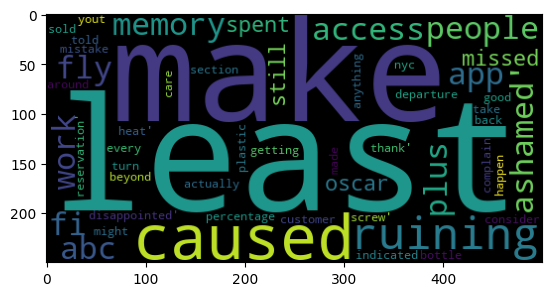

In [84]:
from wordcloud import WordCloud
txt=str(X_train.values)
cloud=WordCloud(width=500,height=250).generate(txt)
plt.imshow(cloud)

In [86]:
tok=Tokenizer(num_words=1000)
tok.fit_on_texts(X_train)

X_train=tok.texts_to_sequences(X_train.values)
X_test=tok.texts_to_sequences(X_test.values)
X_train

AttributeError: 'int' object has no attribute 'lower'

In [87]:
X_train=pad_sequences(X_train)
max_len=X_train.shape[1]
X_train

array([[  0,   0,   0, ...,  78,  38,  95],
       [  0,   0,   0, ..., 239, 557, 387],
       [  0,   0,   0, ..., 423, 247, 985],
       ...,
       [  0,   0,   0, ..., 972, 467, 100],
       [  0,   0,   0, ...,   0,   0,   6],
       [  0,   0,   0, ...,  99,  25, 320]])

In [88]:
X_test=pad_sequences(X_test,maxlen=max_len)

In [89]:
y_train=to_categorical(y_train,num_classes=3)
y_test=to_categorical(y_test,num_classes=3)
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [90]:
np.random.seed(1444)

model=Sequential()

model.add(Embedding(1000,500,input_length=max_len))
model.add(LSTM(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(3,activation='softmax'))


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

history=model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))



Epoch 1/10


646/646 [==============================] - 32s 42ms/step - loss: 0.6585 - accuracy: 0.7272 - val_loss: 0.5521 - val_accuracy: 0.7761
Epoch 2/10
646/646 [==============================] - 25s 39ms/step - loss: 0.4770 - accuracy: 0.8108 - val_loss: 0.4917 - val_accuracy: 0.8032
Epoch 3/10
646/646 [==============================] - 25s 39ms/step - loss: 0.3890 - accuracy: 0.8479 - val_loss: 0.4679 - val_accuracy: 0.8231
Epoch 4/10
646/646 [==============================] - 26s 40ms/step - loss: 0.3272 - accuracy: 0.8739 - val_loss: 0.4119 - val_accuracy: 0.8441
Epoch 5/10
646/646 [==============================] - 25s 38ms/step - loss: 0.2661 - accuracy: 0.8986 - val_loss: 0.4112 - val_accuracy: 0.8614
Epoch 6/10
646/646 [==============================] - 25s 38ms/step - loss: 0.2132 - accuracy: 0.9206 - val_loss: 0.3971 - val_accuracy: 0.8736
Epoch 7/10
646/646 [==============================] - 25s 38ms/step - loss: 0.1726 - accuracy: 0.9361 - val_loss: 0.3996 - val_accur

In [91]:
loss=history.history['loss']
acc=history.history['accuracy']


Text(0.5, 1.0, 'Model Loss')

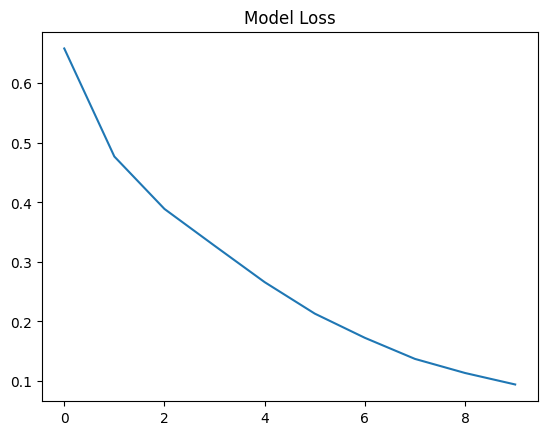

In [93]:
plt.plot(loss)
plt.title("Model Loss")

Text(0.5, 1.0, 'Model Accuracy')

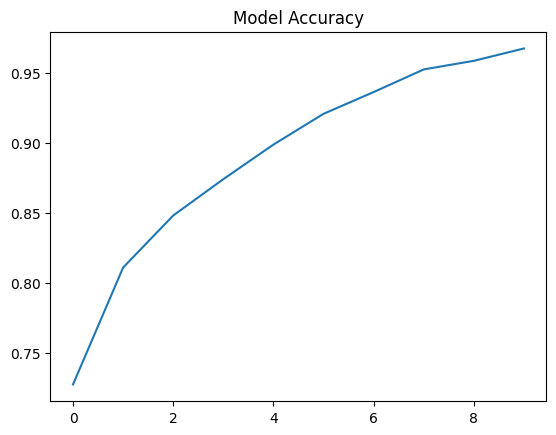

In [96]:
plt.plot(acc)
plt.title("Model Accuracy")

In [97]:
txt="The food flight was very good and enjoyed so much"
txt=preprocess(txt)
txt=tok.texts_to_sequences([txt])
txt=pad_sequences(txt,maxlen=max_len)
pred=np.argmax(model.predict(txt))
print(lbl.classes_[pred])

1/1 [==============================] - 0s 352ms/step
1
